## First steps
Build train/validation/test

Exploratory data analysis

Normalization


## Configuration of neuronal network / Hyperparameters.

Learning rate / Batch size / Epochs

Activation functions / init w / init b

Loss function

Number kernels / Kernel: height, width / Padding / Stride

## Bloques convolucionales
- Convolution layer
- Pooling layer

## Overfitting treatment
- Pooling layer
- Global pooling
- Batch normalization
- L2 regularization (Lasso)

In [ ]:
# TODO Normalization
# TODO Regularization L1 XXX
# TODO Regularization Dropout XXX
# TODO Regularization Max norm constraints XXX
# TODO transfer learning using torchvision
# TODO transfer learning using huggingface
# TODO fine tunning
# TODO Sanity check prediction (correct/wrong)
# TODO Exploratory analysis of data
# TODO Normalize data
# TODO Score XXX
# TODO Sanity check read data
# TODO Use recurrent network to short description
# TODO Use convolutional network to image
# TODO Use fully connected network to metadata

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import statistics
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split


In [ ]:
# random seed
torch.manual_seed(16)
np.random.seed(16)

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001 # optimizer
l2_lambda = 1e-4 # optimizer
l1_lambda = 1e-4

# Images dimensions
image_height = 128
image_width = 128

In [ ]:
# to load custom libraries
sys.path.append("drive/MyDrive/KeepCoding/DeepLearning")

# path to data and libraries
data_path = "drive/MyDrive/KeepCoding/DeepLearning"
from utilsMAP import *

# load dataset
poi_data = pd.read_csv(os.path.join(data_path, "poi_dataset.csv"))

print(f'Number of samples: {poi_data.shape[0]}')
print(f'Number of features: {poi_data.shape[1]}')

Number of samples: 1569
Number of features: 14


In [ ]:
poi_data.head().T

,0,1,2,3,4
id,4b36a3ed-3b28-4bc7-b975-1d48b586db03,e32b3603-a94f-49df-8b31-92445a86377c,0123a69b-13ac-4b65-a5d5-71a95560cff5,390d7d9e-e972-451c-b5e4-f494af15e788,023fc1bf-a1cd-4b9f-af78-48792ab1a294
name,Galería Fran Reus,Convento de San Plácido,Instituto Geológico y Minero de España,Margarita Gil Roësset,Museo del Traje. Centro de Investigación del P...
shortDescription,La Galería Fran Reus es un espacio dedicado a ...,"El Convento de San Plácido en Madrid, fundado ...","El Instituto Geológico y Minero de España, sit...","Margarita Gil Roësset, escultora y poetisa esp...","El Museo del Traje de Madrid, fundado en 2004,..."
categories,"['Escultura', 'Pintura']","['Patrimonio', 'Historia']","['Ciencia', 'Patrimonio']",['Cultura'],"['Patrimonio', 'Cultura']"
tier,1,1,2,1,1
locationLon,2.642262,-3.704467,-3.699694,-3.691228,-3.727822
locationLat,39.572694,40.423037,40.442045,40.427256,40.439665
tags,[],[],[],[],[]
xps,500,500,250,500,500
Visits,10009,10010,10015,10011,10020


In [ ]:
poi_data.dtypes

,0
id,object
name,object
shortDescription,object
categories,object
tier,int64
locationLon,float64
locationLat,float64
tags,object
xps,int64
Visits,int64


In [ ]:
# create estimator for classify samples: high engagement/low engagement
median_bookmarks = statistics.median(poi_data['Bookmarks'])
poi_data['engagement'] = poi_data['Bookmarks']

In [ ]:
# Build train, validation and test datasets
train_set, test_set = train_test_split(poi_data, test_size=0.2, random_state = 16)
train_set, val_set = train_test_split(train_set, test_size=0.15, random_state = 16)

print(f'Full set size: {poi_data.shape[0]}\nTrain set size: {train_set.shape[0]}\nValidation set size: {val_set.shape[0]}\nTest set size: {test_set.shape[0]}')

Full set size: 1569
Train set size: 1066
Validation set size: 189
Test set size: 314


# Prepare data to neuronal network

In [ ]:
# object to build a Dataset.
class POIDataset(Dataset):
  def __init__(self, score, image_path, transform=None):
    self.score = score
    self.image_path = image_path
    self.transform = transform

  def __len__(self):
        return len(self.image_path)

  def __getitem__(self, idx):
        image = Image.open(os.path.join(data_path,self.image_path[idx])).convert('RGB')
        if transform:
          image = transform(image)
        return image, self.score[idx]

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = POIDataset(poi_data.engagement, poi_data.main_image_path, transform=transform)
image, score = train_dataset[0]
score
image.shape
image

tensor([[[0.8431, 0.8627, 0.8824,  ..., 0.9137, 0.9137, 0.9137],
         [0.7059, 0.8510, 0.9412,  ..., 0.9176, 0.9176, 0.9176],
         [0.6314, 0.7647, 0.8549,  ..., 0.9216, 0.9216, 0.9216],
         ...,
         [0.9059, 0.9020, 0.8980,  ..., 0.9922, 0.9922, 0.9922],
         [0.9098, 0.8980, 0.8863,  ..., 0.9922, 0.9922, 0.9882],
         [0.9098, 0.8941, 0.8784,  ..., 0.9922, 0.9882, 0.9882]],

        [[0.8745, 0.8941, 0.9137,  ..., 0.9333, 0.9333, 0.9333],
         [0.7373, 0.8824, 0.9725,  ..., 0.9373, 0.9373, 0.9373],
         [0.6510, 0.7843, 0.8745,  ..., 0.9412, 0.9412, 0.9412],
         ...,
         [0.9020, 0.8980, 0.8980,  ..., 0.9922, 0.9882, 0.9882],
         [0.9059, 0.8941, 0.8902,  ..., 0.9882, 0.9882, 0.9843],
         [0.9059, 0.8902, 0.8824,  ..., 0.9882, 0.9843, 0.9843]],

        [[0.8863, 0.9059, 0.9255,  ..., 0.9490, 0.9490, 0.9490],
         [0.7490, 0.8941, 0.9843,  ..., 0.9529, 0.9529, 0.9529],
         [0.6627, 0.7961, 0.8863,  ..., 0.9569, 0.9569, 0.

Build train, validation and test datasets and dataloaders

In [ ]:
# Create dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = CustomImageDataset(train_set, transform=transform)
val_dataset = CustomImageDataset(val_set, transform=transform)
test_dataset = CustomImageDataset(test_set, transform=transform)

trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

# 1. Convolutional block + fully connected block

In [ ]:
class ConvNet1(nn.Module):
    def __init__(self, heigth, width):
        super(ConvNet1, self).__init__()

        # heigth and width of images
        self.heigth = heigth
        self.width = width

        # Definimos las capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        # Definimos las capas de pooling
        self.pool = nn.MaxPool2d(2, 2) # nn.MaxPool2d(kernel_size, stride=None, ...)

        # Definimos las capas fully connected (clasificador)
        self.fc1 = nn.Linear(64 * self.heigth//8 * self.width//8, 64)
        self.fc2 = nn.Linear(64, 10)

        # Definimos la función de activación
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * self.heigth//8 * self.width//8) # flatten to go from convolutional block to fully connected block
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
model = ConvNet1(image_height,image_width)
parameters_network(model)

Número total de parámetros: 1,105,610

Desglose de parámetros por capa:
conv1.weight: 864 parámetros
conv1.bias: 32 parámetros
conv2.weight: 18,432 parámetros
conv2.bias: 64 parámetros
conv3.weight: 36,864 parámetros
conv3.bias: 64 parámetros
fc1.weight: 1,048,576 parámetros
fc1.bias: 64 parámetros
fc2.weight: 640 parámetros
fc2.bias: 10 parámetros


Device: cuda:0
Epoch 1, Loss: 0.9889693084885093, Acc: 45.684803001876176, Val Loss: 0.7341086268424988, Val Acc: 50.264550264550266
Epoch 2, Loss: 0.7019026735249687, Acc: 52.15759849906191, Val Loss: 0.690502385298411, Val Acc: 57.142857142857146
Epoch 3, Loss: 0.6946801402989555, Acc: 55.0656660412758, Val Loss: 0.708512564500173, Val Acc: 51.32275132275132
Epoch 4, Loss: 0.6660465282552382, Acc: 58.06754221388368, Val Loss: 0.7000078360239664, Val Acc: 57.142857142857146
Epoch 5, Loss: 0.6525247237261604, Acc: 62.38273921200751, Val Loss: 0.7018498380978903, Val Acc: 53.439153439153436
Epoch 6, Loss: 0.6369624172939974, Acc: 62.00750469043152, Val Loss: 0.6819512248039246, Val Acc: 62.43386243386244
Epoch 7, Loss: 0.6024289657087887, Acc: 68.01125703564728, Val Loss: 0.6539452075958252, Val Acc: 61.37566137566137
Epoch 8, Loss: 0.5729785912177142, Acc: 69.32457786116322, Val Loss: 0.6596872011820475, Val Acc: 64.02116402116403
Epoch 9, Loss: 0.5513395071029663, Acc: 72.326454033771

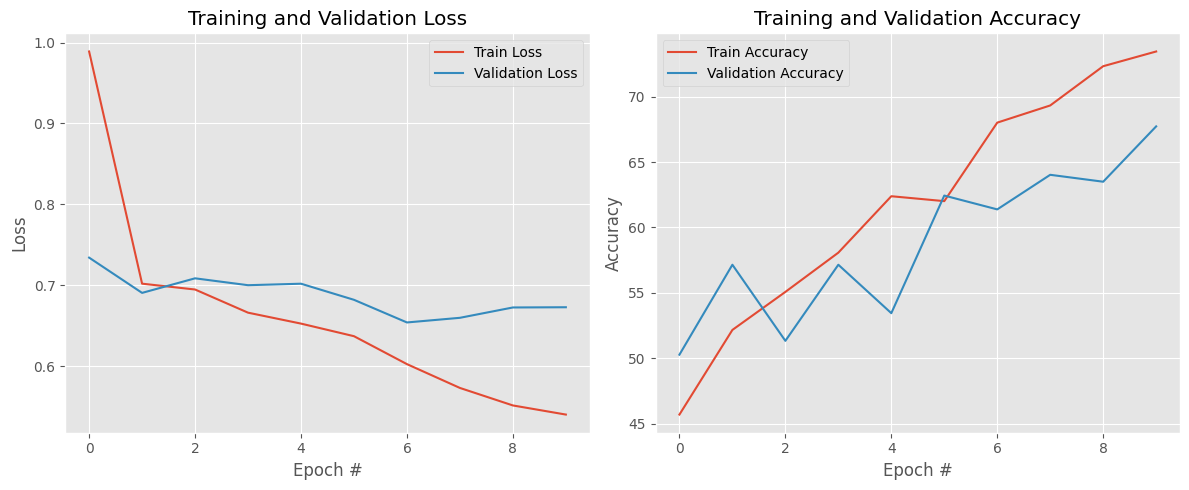

In [ ]:
# train model
model = ConvNet1(image_height, image_width)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, trainloader, valloader, device)


In [ ]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()

        # set convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        # set pooling layer
        self.pool = nn.MaxPool2d(2, 2) # nn.MaxPool2d(kernel_size, stride=None, ...)

        # set fully connected layers (clasificator)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)

        # set activation function
        self.relu = nn.ReLU()

        # Set global pooling (max/avg)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1) # torch.nn.AdaptiveMaxPool2d(output_size,...)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        max_pooled = self.global_max_pool(x).squeeze()
        avg_pooled = self.global_avg_pool(x).squeeze()
        x = torch.cat((max_pooled, avg_pooled), dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = ConvNet2()
parameters_network(model)

Número total de parámetros: 65,226

Desglose de parámetros por capa:
conv1.weight: 864 parámetros
conv1.bias: 32 parámetros
conv2.weight: 18,432 parámetros
conv2.bias: 64 parámetros
conv3.weight: 36,864 parámetros
conv3.bias: 64 parámetros
fc1.weight: 8,192 parámetros
fc1.bias: 64 parámetros
fc2.weight: 640 parámetros
fc2.bias: 10 parámetros


Device: cuda:0
Epoch 1, Loss: 1.3975138664245605, Acc: 43.33958724202627, Val Loss: 0.7096795638402303, Val Acc: 50.79365079365079
Epoch 2, Loss: 0.7385935082155115, Acc: 49.62476547842402, Val Loss: 0.875871479511261, Val Acc: 49.735449735449734
Epoch 3, Loss: 0.7348138444563922, Acc: 50.37523452157598, Val Loss: 0.7047929565111796, Val Acc: 50.79365079365079
Epoch 4, Loss: 0.7019404593636008, Acc: 52.25140712945591, Val Loss: 0.7028347055117289, Val Acc: 50.79365079365079
Epoch 5, Loss: 0.7078874461791095, Acc: 48.405253283302066, Val Loss: 0.7060198187828064, Val Acc: 50.79365079365079
Epoch 6, Loss: 0.6933174413793227, Acc: 52.25140712945591, Val Loss: 0.6962117155392965, Val Acc: 52.38095238095238
Epoch 7, Loss: 0.6913825729314018, Acc: 53.00187617260788, Val Loss: 0.6880874832471212, Val Acc: 55.55555555555556
Epoch 8, Loss: 0.6858657282941482, Acc: 56.66041275797373, Val Loss: 0.6820083856582642, Val Acc: 57.67195767195767
Epoch 9, Loss: 0.6656780102673698, Acc: 59.5684803001876

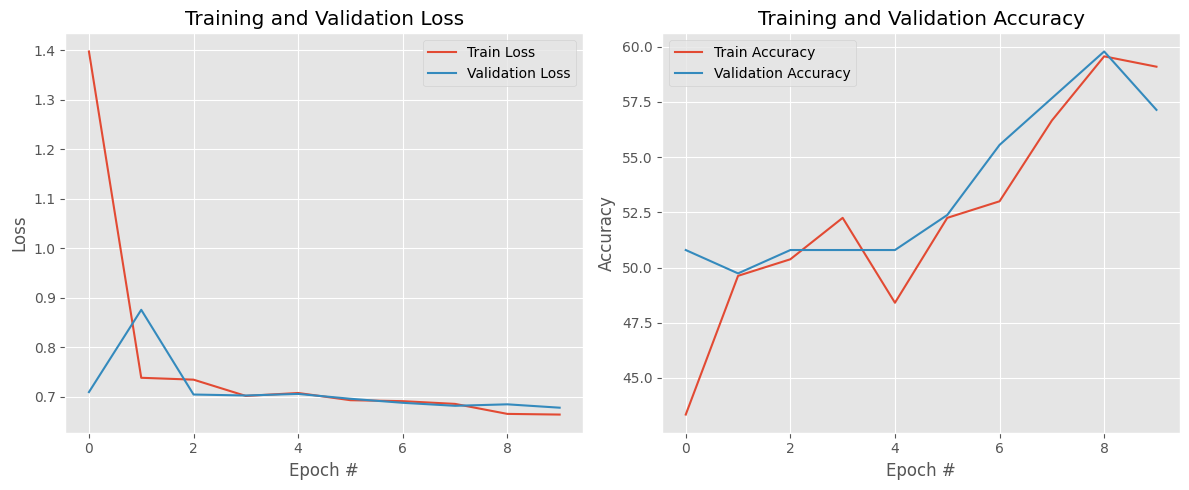

In [ ]:
# train model
model = ConvNet2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, trainloader, valloader, device)


# 3. Add batch normalization + layer definition

In [ ]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()

        # first convolutional layer + BatchNormal + ReLu + MaxPool
        self.layer1 = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding=1), # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)
          nn.BatchNorm2d(32), # nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1,
          nn.ReLU(),
          nn.MaxPool2d(2,2) # nn.MaxPool2d(kernel_size, stride=None, ...)
        )

        # second convolutional layer + BatchNormal + ReLu + MaxPool
        self.layer2 = nn.Sequential(
          nn.Conv2d(32, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
        )

        # third convolutional layer + BatchNormal + ReLu + MaxPool
        self.layer3 = nn.Sequential(
          nn.Conv2d(64, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2,2)
        )

        # global pooling
        self.global_max_pool = nn.AdaptiveMaxPool2d(1) # torch.nn.AdaptiveMaxPool2d(output_size,...)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # fully connected layers (classifier)
        self.fc = nn.Sequential(
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        max_pooled = self.global_max_pool(x).squeeze()
        avg_pooled = self.global_avg_pool(x).squeeze()
        x = torch.cat((max_pooled, avg_pooled), dim=1)
        x = self.fc(x)
        return x

In [ ]:
model = ConvNet3()
parameters_network(model)

Número total de parámetros: 65,674

Desglose de parámetros por capa:
layer1.0.weight: 864 parámetros
layer1.0.bias: 32 parámetros
layer1.1.weight: 32 parámetros
layer1.1.bias: 32 parámetros
layer2.0.weight: 18,432 parámetros
layer2.0.bias: 64 parámetros
layer2.1.weight: 64 parámetros
layer2.1.bias: 64 parámetros
layer3.0.weight: 36,864 parámetros
layer3.0.bias: 64 parámetros
layer3.1.weight: 64 parámetros
layer3.1.bias: 64 parámetros
fc.0.weight: 8,192 parámetros
fc.0.bias: 64 parámetros
fc.1.weight: 64 parámetros
fc.1.bias: 64 parámetros
fc.3.weight: 640 parámetros
fc.3.bias: 10 parámetros


Device: cuda:0
Epoch 1, Loss: 1.806171830962686, Acc: 57.129455909943715, Val Loss: 1.5540647904078166, Val Acc: 50.264550264550266
Epoch 2, Loss: 1.1354620526818668, Acc: 74.48405253283302, Val Loss: 1.1000148852666218, Val Acc: 52.91005291005291
Epoch 3, Loss: 0.8122966850505156, Acc: 76.92307692307692, Val Loss: 0.8530234297116598, Val Acc: 65.07936507936508
Epoch 4, Loss: 0.6458184158100801, Acc: 77.67354596622889, Val Loss: 0.7276185949643453, Val Acc: 74.07407407407408
Epoch 5, Loss: 0.5298722474014058, Acc: 81.70731707317073, Val Loss: 0.7023245493570963, Val Acc: 69.84126984126983
Epoch 6, Loss: 0.45054492354393005, Acc: 84.9906191369606, Val Loss: 0.8047505617141724, Val Acc: 64.02116402116403
Epoch 7, Loss: 0.3740873976665385, Acc: 87.61726078799249, Val Loss: 0.6855698029200236, Val Acc: 73.54497354497354
Epoch 8, Loss: 0.32646341358914094, Acc: 90.15009380863039, Val Loss: 0.7189120054244995, Val Acc: 70.37037037037037
Epoch 9, Loss: 0.28465190179207744, Acc: 91.27579737335

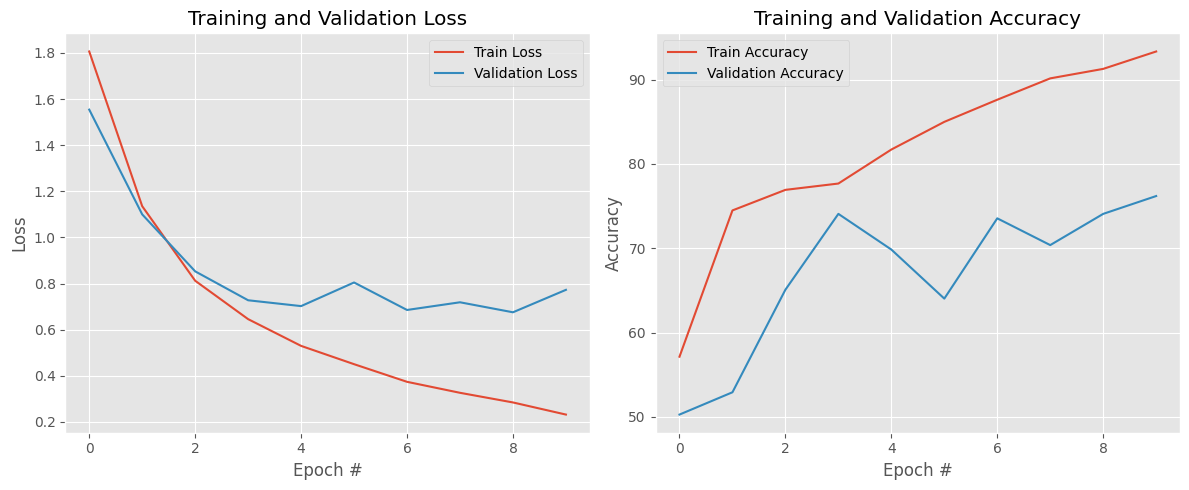

In [ ]:
# train model
model = ConvNet3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, trainloader, valloader, device)


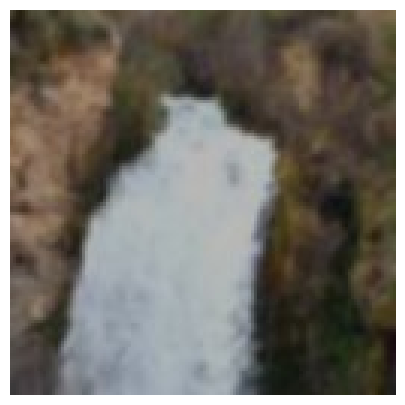

In [ ]:
from PIL import Image

path_data = "drive/MyDrive/KeepCoding/DeepLearning/data_main"
file_name = "main.jpg"
img_path = path_data + "/"+ "0b6e785b-c995-48a6-a9bd-dd4ceb5eb8d0" + "/" + file_name

image = Image.open(img_path).convert('RGB')

# Visualizar la imagen
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

Test model

In [ ]:
# TODO test model
#accuracy = evaluate_model(model, testloader, device)
#print('Test accuracy: %.3f' % accuracy)

#plot_training_curves(train_losses, val_losses, train_accs, val_accs, num_epochs, test_acc=accuracy)

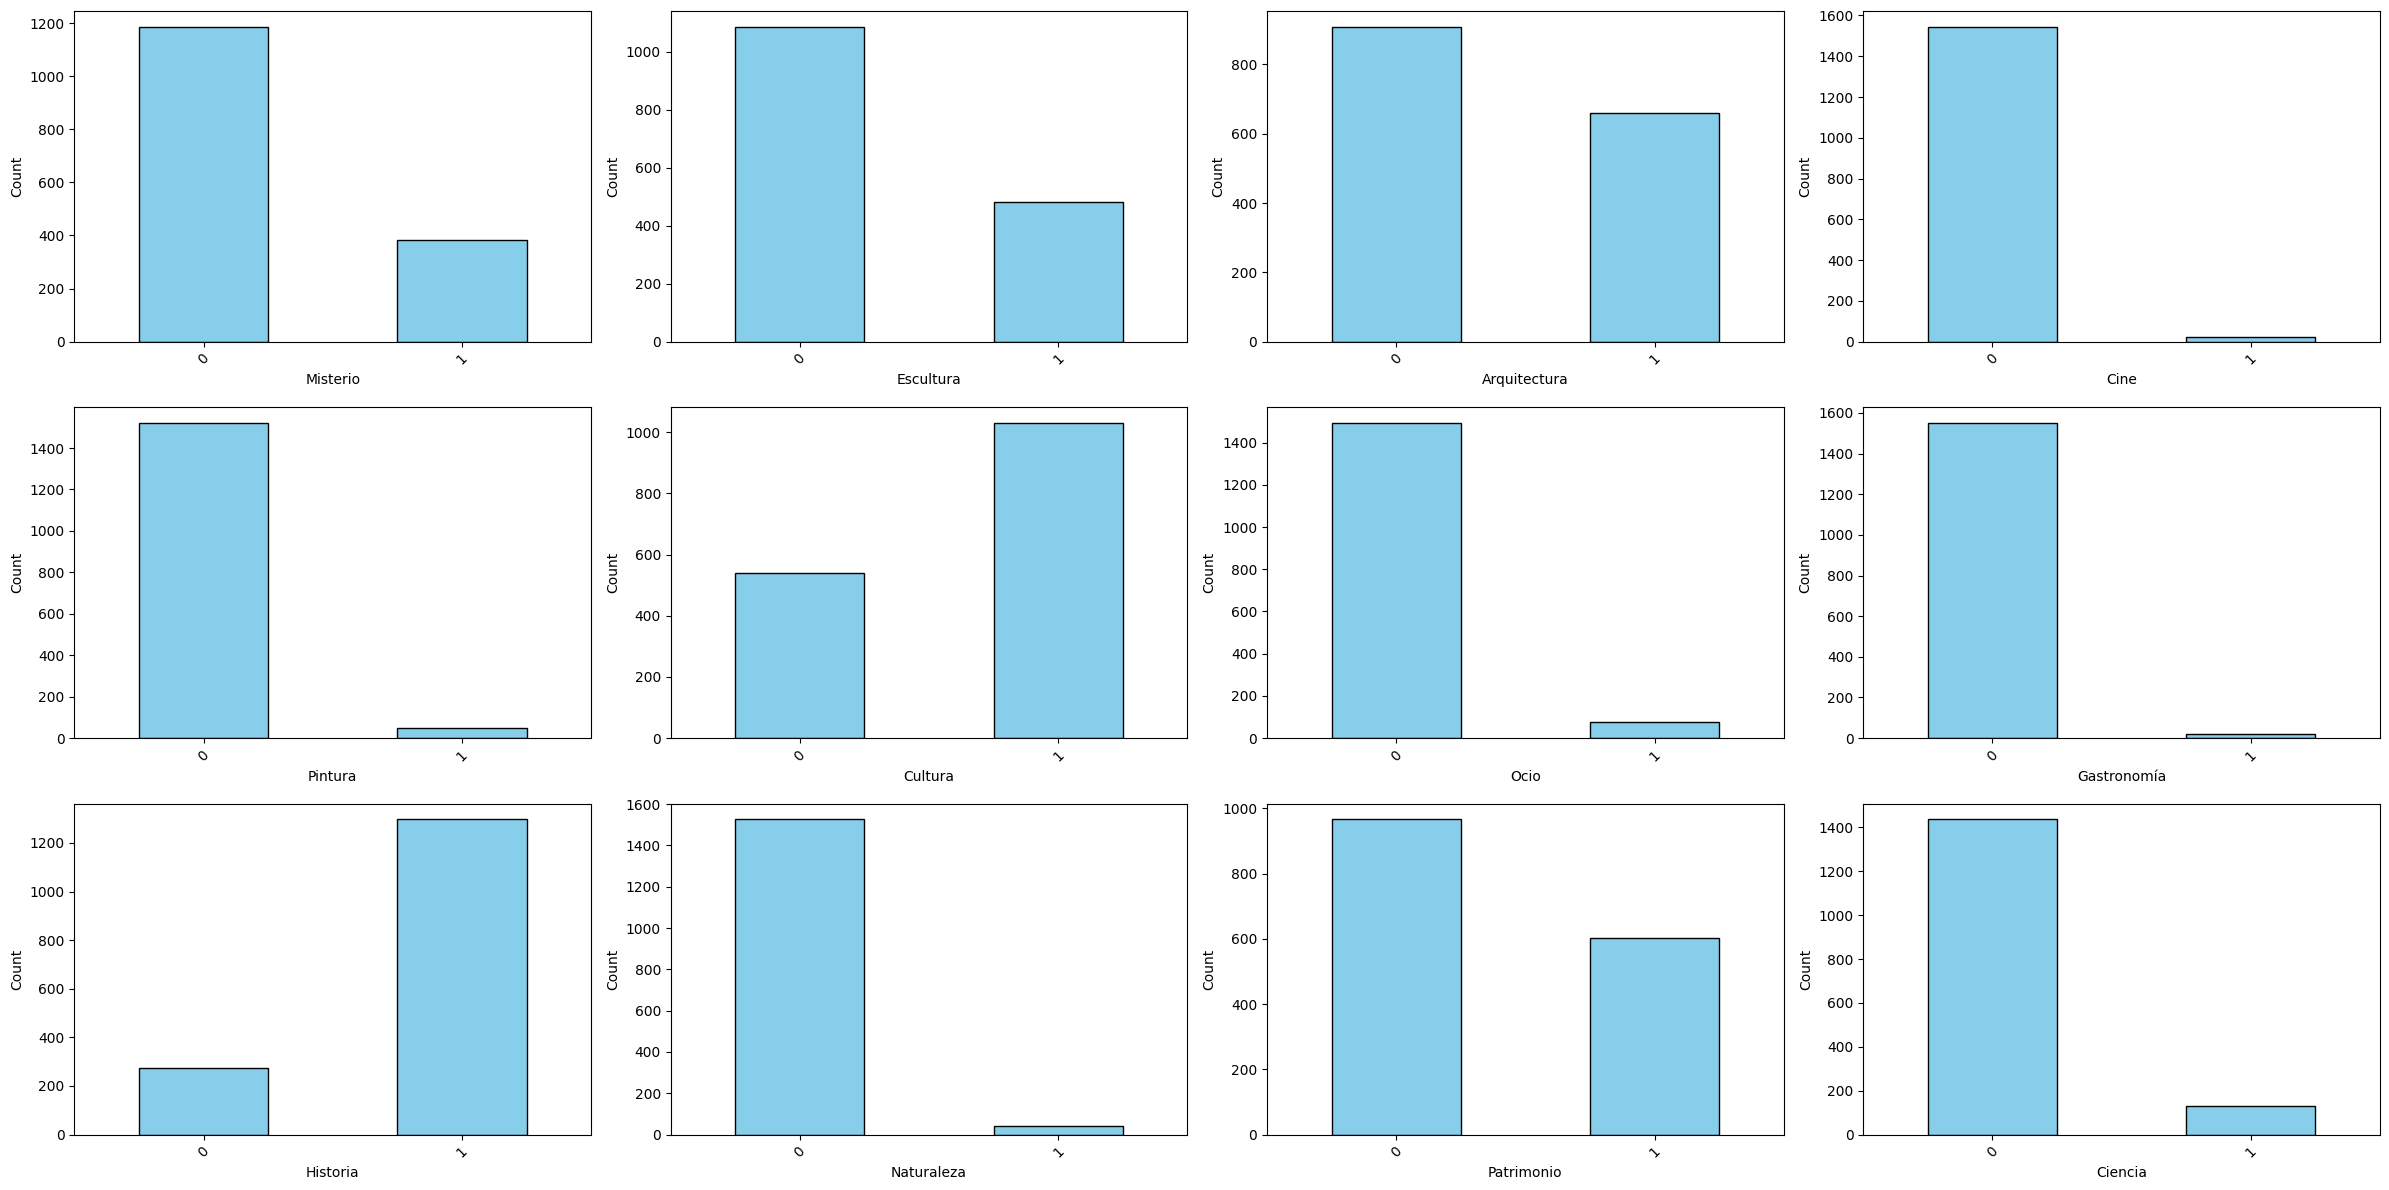

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize and fit the encoder
mlb = MultiLabelBinarizer()
categories_one_hot = mlb.fit_transform(poi_data['list_categories'])

# Convert to DataFrame with proper column names
df_categories_one_hot = pd.DataFrame(categories_one_hot, columns=mlb.classes_)

# Concatenate with original DataFrame
#df_encoded = pd.concat([df, one_hot_df], axis=1)

# Bar plots for each category
# TODO Sort by most frequent
#plot_bars(df_categories_one_hot, categories, 3, 4)
df_categories_one_hot

## FCNN optim number layers + layer size

In [ ]:
# Hyperparameters
num_epochs = 5 # ???
batch_size = 128 # ???
learning_rate = 0.01 # ???
l2_lambda = 1e-4 # ???
l1_lambda = 1e-4 # ???
step_size = 2 # ???
gamma = 0.1 # ???
dropout_rate = 0.2 # ???
number_layers = 2 # 1, 2, 3, 4, 5
layer_size = 32 # ???
act_funct = nn.ReLU() # ????

In [ ]:
# Define Fully-connected NN
class FCNetLayers(nn.Module):
    def __init__(self, dropout_rate, layer_size, act_funct):
        super(FCNetLayers, self).__init__()
        self.number_layers = number_layers
        # First fully connected layer
        self.layerin = nn.Sequential(
            nn.Linear(20, layer_size),
            nn.BatchNorm1d(layer_size),
            act_funct,
            nn.Dropout(dropout_rate)
        )

        # Second fully connected layer
        self.layerdeep = nn.Sequential(
            nn.Linear(layer_size, layer_size),
            nn.BatchNorm1d(layer_size),
            act_funct,
            nn.Dropout(dropout_rate)
        )

        # Output fully connected layer
        self.layerout = nn.Sequential(
            nn.Linear(layer_size, 3)
        )

    def forward(self, x):
        x = self.layerin(x)
        for i in range(self.number_layers):
          x = self.layerdeep(x)
        x = self.layerout(x)
        return x

Device: cpu
Epoch 1, Loss: 1.200155720114708, Acc: 4.9800796812749, Val Loss: 1.1295284032821655, Val Acc: 5.577689243027889, LR: 0.01
Epoch 2, Loss: 1.0874915570020676, Acc: 10.557768924302788, Val Loss: 1.0751914381980896, Val Acc: 71.31474103585657, LR: 0.001
Epoch 3, Loss: 1.0363108664751053, Acc: 75.69721115537848, Val Loss: 1.0654371976852417, Val Acc: 71.31474103585657, LR: 0.001
Epoch 4, Loss: 1.0285886824131012, Acc: 75.69721115537848, Val Loss: 1.0562503933906555, Val Acc: 71.31474103585657, LR: 0.0001
Epoch 5, Loss: 1.0222743228077888, Acc: 75.2988047808765, Val Loss: 1.051023542881012, Val Acc: 71.31474103585657, LR: 0.0001


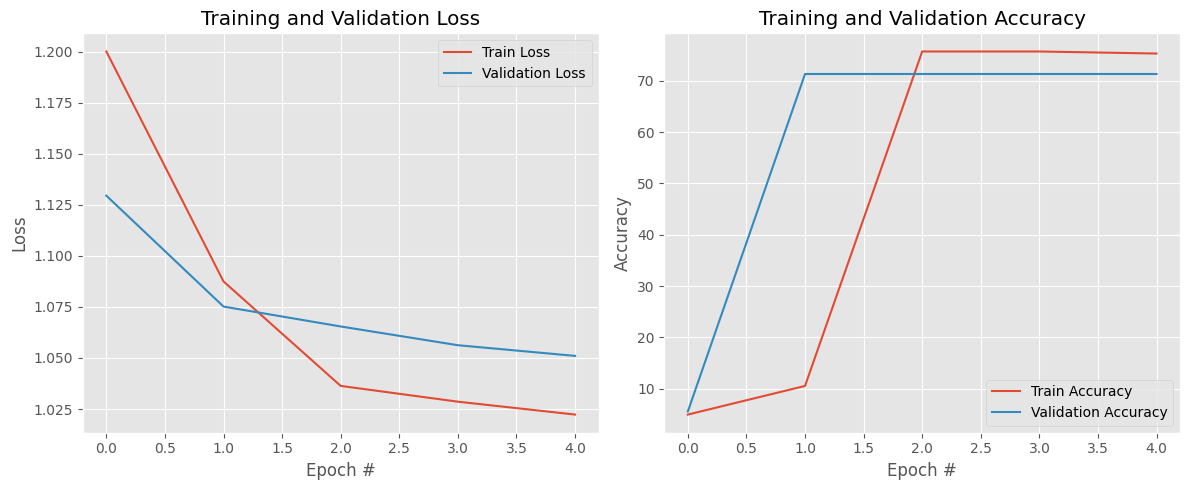

In [ ]:
# train model
model = FCNetLayers(dropout_rate, number_layers, act_funct)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, l1_lambda=l1_lambda, scheduler = scheduler)


In [ ]:
def objective(trial):
    """
    Función objetivo para la optimización de hiperparámetros con Optuna.
    """

    # Generamos una semilla para reproducibilidad
    #trial_seed = random.randint(1, 200)
    #trial.set_user_attr("seed", trial_seed)
    #print(f"\n🎲 Usando semilla: {trial_seed}")

    # Fijamos la semilla
    #set_random_seed(trial_seed)
    set_random_seed()

    # Definimos los hiperparámetros a optimizar
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-4, 1e-1, log =True)
    l1_lambda = trial.suggest_float("l1_lambda", 1e-4, 1e-1, log =True)
    step_size = trial.suggest_int("step_size", 1, 3)
    gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log =True)
    layer_size = trial.suggest_int("layer_size", 16, 256)
    number_layers = trial.suggest_int("number_layers", 1, 3)
    act_funct = trial.suggest_categorical("act_funct",["ReLU", "LeakyReLU", "Sigmoid"])

    if act_funct == "ReLU":
      funct = nn.ReLU()
    elif act_funct == "LeakyReLU":
      funct = nn.LeakyReLU()
    elif act_funct == "Sigmoid":
      funct = nn.Sigmoid()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Creamos el modelo y lo movemos al dispositivo
    model = FCNetLayers(dropout_rate, number_layers, funct).to(device)

    # Definimos el optimizador y la función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    # Inicializamos listas para almacenar las métricas
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Entrenamos por 5 épocas
    for epoch in range(5):
        train_loss, train_acc, _ = train_epoch(model, device, train_loader, criterion, optimizer,
                                            l1_lambda = l1_lambda, scheduler = scheduler)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # Guardamos las métricas de entrenamiento y validación
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Guardamos las métricas en un archivo
    output_metrics_file = os.path.join(data_path,"FCNN1",f"metrics_{trial.number}.pkl")
    with open(output_metrics_file, "wb") as f:
        pickle.dump({"train_losses": train_losses,
                     "train_accs": train_accs,
                    "val_losses": val_losses,
                    "val_accs": val_accs}, f)

    # Guardamos el path de las métricas como parámetro de usuario
    trial.set_user_attr("metrics_path", output_metrics_file)

    return val_accs[-1]

In [ ]:
# Creamos un estudio de optuna
# Eliminamos el estudio si existe
try:
    optuna.delete_study(study_name="fcn_optimization", storage=os.path.join("sqlite:///",data_path,"FCNN2","fcn_study.sqlite3"))
except:
    pass

study = optuna.create_study(study_name="fcn_optimization", direction="maximize",
                            storage=os.path.join("sqlite:///",data_path,"FCNN2","fcn_study.sqlite3"),
                            sampler=optuna.samplers.TPESampler())

# Optimizamos con 81 trials (todo el espacio de búsqueda)
n_trials = 32

[I 2025-06-02 16:38:20,082] A new study created in RDB with name: fcn_optimization


In [ ]:
# Reading the .pkl file
with open(os.path.join(data_path,'FCNN/metrics_0.pkl'), 'rb') as f:  # 'rb' stands for read binary
    data = pickle.load(f)

print(data)
df = pd.DataFrame(data)

{'train_losses': [1.1974678933620453, 1.0954298824071884, 1.0636186599731445, 1.0557710081338882, 1.063887432217598], 'train_accs': [45.71713147410359, 55.876494023904385, 62.25099601593625, 62.74900398406375, 59.16334661354582], 'val_losses': [1.0448846817016602, 1.007385402917862, 1.0132290422916412, 1.0097723007202148, 1.014280378818512], 'val_accs': [71.31474103585657, 71.31474103585657, 70.91633466135458, 66.93227091633466, 59.7609561752988]}


In [ ]:
# Reading sqlite database
study = optuna.load_study(
    study_name="fcn_optimization",
    storage=os.path.join("sqlite:///",data_path,"fcn_study.sqlite3"),
)
print(f"Estudio cargado con {len(study.trials)} trials completados")


Estudio cargado con 32 trials completados


In [ ]:
study.trials[1].params['act_funct']
study.trials[1].user_attrs['metrics_path']
#study.trials[1].params['metrics_path']

'drive/MyDrive/KeepCoding/DeepLearning/FCNN/metrics_1.pkl'

Epoch 1, Loss: 0.8924427852034569, Acc: 77.49003984063745, Val Loss: 0.867513120174408, Val Acc: 71.31474103585657, LR: 1e-05
Epoch 2, Loss: 0.8936095014214516, Acc: 77.49003984063745, Val Loss: 0.868105947971344, Val Acc: 71.31474103585657, LR: 1e-05
Epoch 3, Loss: 0.8907299116253853, Acc: 77.49003984063745, Val Loss: 0.8677689135074615, Val Acc: 71.31474103585657, LR: 1.0000000000000002e-06
Epoch 4, Loss: 0.890350379049778, Acc: 77.49003984063745, Val Loss: 0.8665741682052612, Val Acc: 71.31474103585657, LR: 1.0000000000000002e-06
Epoch 5, Loss: 0.8944307267665863, Acc: 77.49003984063745, Val Loss: 0.8669217526912689, Val Acc: 71.31474103585657, LR: 1.0000000000000002e-07

🎯 Precisión en Test: 77.07%


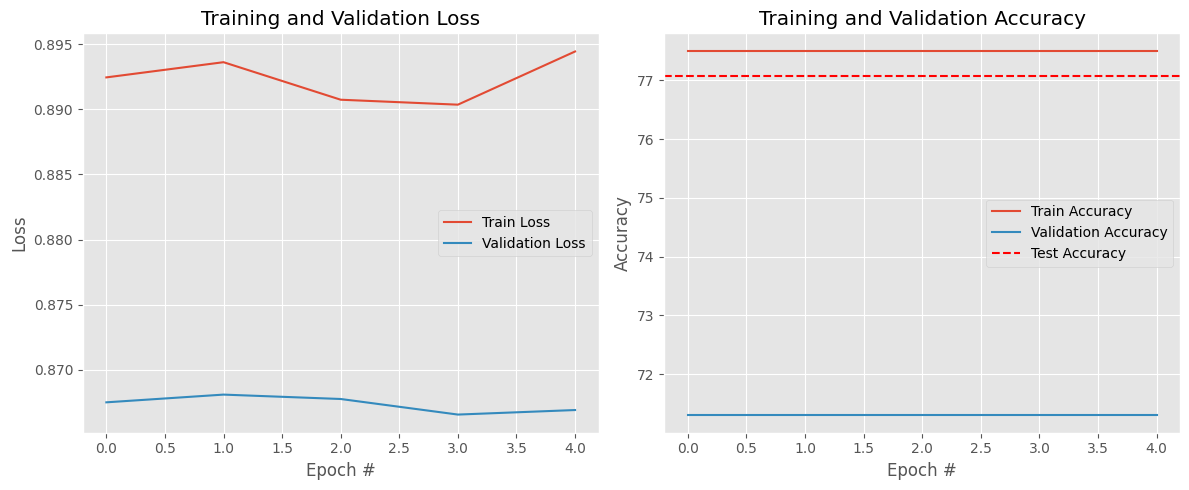

In [ ]:
# Test model
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

trial = study.best_trial
# Set hyperparameters to best trial
learning_rate = trial.params['learning_rate']
l2_lambda = trial.params['l2_lambda']
l1_lambda = trial.params['l1_lambda']
step_size = trial.params['step_size']
gamma = trial.params['gamma']
dropout_rate = trial.params['dropout_rate']
number_layers = trial.params['number_layers']
layer_size = trial.params['layer_size']
act_funct = trial.params['act_funct']
# Train model
train_test_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, test_loader,
            device, l1_lambda=l1_lambda, scheduler = scheduler)
# TODO Sanity check results